# Practical to Compare How Different Bias Correction Techniques Compare for Seasonal Forecasts
In this practical, we will use some forecast models to generate some seasonal precipitation forecasts, and then assess how different techniques compare to bias correct these seasonal precipitation forecasts.

Bias correction techniques assessed will include **(1)** Canonical Correlation Analysis (CCA), which bias corrects the forecasts using a large scale correlation patterns over a spatial domain, **(2)** Extended Logistic Regression (ELR), and **(3)** Ensemble Probabalistic Output Extreme Learning Machine (EPOELM), which are two grid-based bias-correction techniques that do a grid by grid cell adjustment to the raw forecasts.

**This notebook should be run in the intdesk_train environment - check your kernel (upper righthand corner) is set to 'intdesk_train', so you have all necessary libraries**

## Libraries

In [1]:
import xcast as xc
import datetime as dt
from datetime import datetime
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob
from cartopy.feature import NaturalEarthFeature

## Project Directory Setup
setup the folder where you want to work for this project

either set project_dir equal to the location of your working directory, e.g. "/Users/katie/Desktop/pacisl_training" or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()

In [2]:
project_dir = os.getcwd()
print('Project Directory is Located in ' + project_dir)

#makes subdirectores to organize your work within the project if they don't already exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(project_dir, 'practical_figures'), exist_ok = True)
figure_dir = os.path.join(project_dir, 'practical_figures')

Project Directory is Located in /cpc/int_desk/pac_isl/analysis/xcast/seasonal/practical_notebooks


### Add all of your data for this practical into your 'practical_data' folder now

## Setup Your Constants: Spatial Extents and Dates

**(1) initialization date**: Make sure this date is not set for a future month but in a present or past month, and then seasonal forecasts will be created for 3 target periods following that month. For instance if you pick (2023,8,1) as your initialization date, you will evaluate forecasts over Sep-Nov, Oct-Dec, and Dec-Feb.

In [4]:
## PICK YOUR DATE you want to initialize the model, e.g. your current date
initial_date = (2023, 9, 1)

In [5]:
#REGION OF INTEREST
#some predefined zones, update the numbers or add another zone following the same labelling structure
pacislands_coordinates = {
    'west': 130,
    'east': 205,
    'north': 8,
    'south': -20
    }

chuuk_coordinates = {
    'west': 151,
    'east': 153,
    'north': 8,
    'south': 6
    }

fiji_coordinates = {
    'west':  177,
    'east': 182,  
    'north': -15,  
    'south': -20}

kiribati_coordinates = {
        'west':  202,
        'east': 203,  
        'north': 3,  
        'south': 1}

solomon_coordinates = {
        'west':  155,
        'east': 167,  
        'north': -6,  
        'south': -13}

png_coordinates = {
        'west':  130,
        'east': 156,  
        'north': 1,  
        'south': -12}
        
palau_coordinates = {
        'west':  133,
        'east': 135,  
        'north': 8,  
        'south': 6
}
        
vanuatu_coordinates = {
        'west':  165,
        'east': 170,  
        'north': -12,  
        'south': -20
}

samoa_coordinates = {
        'west':  187,
        'east': 191,  
        'north': -13,  
        'south': -15
}

tuvalu_coordinates = {
        'west':  178,
        'east': 180,  
        'north': -8,  
        'south': -9
}

**(2) region of interest**: Several coordinates have been setup in this cell. Make sure your region_coords variable is equal to the name of one of the coordinate dictionary entries in this cell, and then name that region as you like, e.g. region_coords = solomon_coordinates, region_of_interest = 'Solomon Islands'.
You can adjust the coordinate values as you like in the dictionaries if you want to play around with the predictand extent, just remember to keep the naming consistent.

In [6]:
### PICK YOUR TARGET REGION OF INTEREST
region_of_interest = 'Vanuatu' #how you want to name your region (can include spaces)
region_coords = vanuatu_coordinates #name of the coordinates to use for your region, as defined above

**(3) predictor training extent**: If you find a particular spatial extent for your predictors improves your CCA bias correction technique in the CCA_practice notebook, feel free to update the predictor_train_extent coordinates below, otherwise can leave as is

In [7]:
### YOUR PREDICTOR TRAINING ZONE
predictor_train_extent = {
    'west': 120,
    'east': 210,
    'north': 10,
    'south': -30
}
predictor_train_extent_name = 'Pacific'

## Prepare Data for Analysis

In [8]:
#this cell is setup to calculate your target forecast months based on your initialization date
#the forecast months are currently seto to be 1-3, 2-4 and 3-5 months ahead
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

leads = [['1', '3'],['2', '4'], ['3','5']]
initial_month = dt.datetime(*initial_date).month
initial_month_name = number_to_month_name_dictionary[initial_month]
target_seas = []
for l in leads:
    target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
    target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
    target_seas.append('-'.join([target_low, target_high]))
print('Target seasons to forecast')
print(target_seas)

Target seasons to forecast
['Oct-Dec', 'Nov-Jan', 'Dec-Feb']


### Load Observations and Model Data

In [9]:
obs_leads = xr.open_dataset(os.path.join(data_dir, '_'.join([initial_month_name, 'threeseas_CMORPH_precip.nc'])))

#train the model on observations over a grid slightly larger than the region of interest
#this could be updated for later fine-tuning, but calculated here to keep it simple for now
predictand_train_extent = {
    'west':  region_coords['west']-5,
        'east': region_coords['east']+5,  
        'north': region_coords['north']+3,  
        'south': region_coords['south']-2
}
obs_leads = obs_leads.sel(X=slice(predictand_train_extent['west'], predictand_train_extent['east']),
                          Y=slice(predictand_train_extent['south'], predictand_train_extent['north']))
print(obs_leads)

# read in hindcast and forecast data
hindcast_data = xr.open_dataset(os.path.join(data_dir, '_'.join([initial_month_name, 'threeseas_NMME_hcst_precip.nc'])))
forecast_data = xr.open_dataset(os.path.join(data_dir, '_'.join([initial_month_name, 'threeseas_NMME_fcst_precip.nc'])))

hindcast_data = hindcast_data.sel(X=slice(predictor_train_extent['west'], predictor_train_extent['east']),
                          Y=slice(predictor_train_extent['south'], predictor_train_extent['north']))
forecast_data = forecast_data.sel(X=slice(predictor_train_extent['west'], predictor_train_extent['east']),
                          Y=slice(predictor_train_extent['south'], predictor_train_extent['north']))

#read in the ocean mask for the region (makes it easier to see the plots)
msk = xr.open_dataset(os.path.join(data_dir, 'pacific_mask.nc'))
mskk = msk.amask.expand_dims({'M':[0]})
mskk = mskk.assign_coords({'lon': [i + 360 if i <= 0 else i for i in mskk.coords['lon'].values]}).sortby('lon').drop_duplicates('lon')
mskk = mskk.rename({'lon':'X', 'lat':'Y', 'time':'T'})
mskk = xc.regrid(mskk, obs_leads.X, obs_leads.Y)
mask_missing = mskk.mean('T', skipna=False).mean('M', skipna=False)
mask_missing = xr.ones_like(mask_missing).where(~np.isnan(mask_missing), other=np.nan )

if region_coords == chuuk_coordinates:
    obs_leads = obs_leads.copy()
else:
    obs_leads = obs_leads * mask_missing

<xarray.Dataset>
Dimensions:  (L: 3, M: 1, Y: 45, X: 61, T: 75)
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) int64 0
  * Y        (Y) float32 -20.0 -19.75 -19.5 -19.25 ... -9.75 -9.5 -9.25 -9.0
  * X        (X) float32 160.0 160.2 160.5 160.8 ... 174.2 174.5 174.8 175.0
  * T        (T) datetime64[ns] 2023-09-01 2024-09-01 ... 2096-09-01 2097-09-01
Data variables:
    precip   (L, M, T, Y, X) float64 ...


#### Check your region of interest is what you want,don't worry about the 'T' value as much as the spatial extent being correct

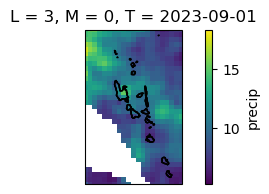

In [15]:
obs_check = obs_leads.sel(X=slice(predictand_train_extent['west'], predictand_train_extent['east']),
                          Y=slice(predictand_train_extent['south'], predictand_train_extent['north']))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes._autoscaleXon = False
axes._autoscaleYon = False

# Your plotting code here using the specific model and season
xplot = obs_check.isel(T=0, L=2).precip.plot(ax=axes,
                                 transform=ccrs.PlateCarree())
axes.coastlines()
c = axes.coastlines()
# Add country borders
axes.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                    scale='50m', edgecolor='black', facecolor='none'))
# Set the extent to cover the specific area
axes.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())

#### Check your model data is what you want, don't worry about the 'T' value as much as the spatial extent being correct

<xarray.DataArray 'precip' (M: 1, Y: 41, X: 91)>
[3731 values with dtype=float64]
Coordinates:
  * M        (M) object 'NMME'
  * Y        (Y) float32 -30.0 -29.0 -28.0 -27.0 -26.0 ... 6.0 7.0 8.0 9.0 10.0
  * X        (X) float32 120.0 121.0 122.0 123.0 ... 207.0 208.0 209.0 210.0
    T        datetime64[ns] 2023-09-01
    L        int64 3
Attributes:
    units:          mm
    standard_name:  precip


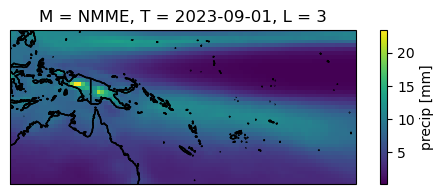

In [16]:
model_check = hindcast_data.sel(X=slice(predictor_train_extent['west'], predictor_train_extent['east']),
                          Y=slice(predictor_train_extent['south'], predictor_train_extent['north']))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes._autoscaleXon = False
axes._autoscaleYon = False
print(model_check.isel(T=0, L=2).precip)
# Your plotting code here using the specific model and season
xplot = model_check.isel(T=0, L=2).precip.plot(ax=axes,
                                 transform=ccrs.PlateCarree())
axes.coastlines()
c = axes.coastlines()
# Add country borders
axes.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                    scale='50m', edgecolor='black', facecolor='none'))
# Set the extent to cover the specific area
axes.set_extent([predictor_train_extent['west'], predictor_train_extent['east'], predictor_train_extent['south'], predictor_train_extent['north']], crs=ccrs.PlateCarree())

## Analysis

### Bias correct raw model outputs using CCA

In [11]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, obs_to_test, raw_to_test = [],[],[],[],[],[]

for l in np.unique(hindcast_data.L):
    obs = obs_leads.sel(L=l).precip
    model = hindcast_data.sel(L=l).precip
    fmodel = forecast_data.sel(L=l).precip

    #run CCA
    hindcasts_det, hindcasts_prob, obs_test, raw_test = [], [], [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=5):
        print("window {}".format(i))
        i += 1
        reg_CCA = xc.CCA(search_override=(5,
                                      5,
                                     3))
        reg_CCA.fit(xtrain, ytrain)
        preds = reg_CCA.predict(xtest)
        probs =  reg_CCA.predict_proba(xtest)
        obs_test.append(ytest)
        raw_test.append(xtest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    obs_test = xr.concat(obs_test, 'T')
    raw_test = xr.concat(raw_test, 'T')
    
    fprobs =  reg_CCA.predict_proba(fmodel)
    
    cca_fcsts_prob.append(fprobs)
    cca_hcasts_det.append(hindcasts_det)
    cca_hcasts_prob.append(hindcasts_prob)
    obs_to_test.append(obs_test)
    raw_to_test.append(raw_test)

cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
obs_to_test = xr.concat(obs_to_test, dim = 'L')
raw_to_test = xr.concat(raw_to_test, dim = 'L')
print('cca processing time is ' + str(time.time() - start_time))

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 33
window 34
window 35
window 36
window 37
window 38
window 39
window 40
window 41
window 42
window 43
window 44
window 45
window 46
window 47
window 48
window 49
window 50
window 51
window 52
window 53
window 54
window 55
window 56
window 57
window 58
window 59
window 60
window 61
window 62
window 63
window 64
window 65
window 66
window 67
window 68
window 69
window 70
window 71
window 72
window 73
window 74
window 75
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 2

In [ ]:
#grab the necessary functions
import importlib.util

#onehotupdate.py file and where it is located
function_folder = "/cpc/int_desk/pac_isl/analysis/xcast/seasonal/onehotupdate.py"

spec = importlib.util.spec_from_file_location(
"onehotupdate", function_folder)    

onehot = importlib.util.module_from_spec(spec) 
spec.loader.exec_module(onehot)### Bias correct raw model outputs using grid-based techniques (ELR, EPOELM)

In [20]:
#grab the necessary functions
import importlib.util

#onehotupdate.py file and where it is located
function_folder1 = "/cpc/int_desk/pac_isl/analysis/xcast/seasonal/MLtrain.py"

spec1 = importlib.util.spec_from_file_location(
"MLtrain", function_folder1)    

ELRupdate = importlib.util.module_from_spec(spec1) 
spec1.loader.exec_module(ELRupdate)
# automatically reloads the configuration file once updated and saved so you don't have to restart the kernel
%load_ext autoreload
%autoreload 2

In [21]:
start_time = time.time()
elr_fcsts_prob, elr_fcsts_det, elr_hcasts_det, elr_hcasts_prob = [], [], [], []
epoelm_fcsts_prob, epoelm_fcsts_det, epoelm_hcasts_det, epoelm_hcasts_prob = [], [], [], []
obs_to_test_grid, raw_to_test_grid = [],[]

for l in np.unique(hindcast_data.L):
    obs = obs_leads.sel(L=l).precip
    model = hindcast_data.sel(L=l).precip
    fmodel = forecast_data.sel(L=l).precip
    
    model_regrid = xc.regrid(model, obs.X, obs.Y)
    fmodel_regrid = xc.regrid(fmodel, obs.X, obs.Y)

    obs, model_regrid = xc.match(obs, model_regrid)

    #run ELR, EPOELM
    hindcasts_det_ELR, hindcasts_prob_ELR, hindcasts_det_EPOELM, hindcasts_prob_EPOELM, obs_test_grid, raw_test_grid = [], [], [], [], [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model_regrid, obs, window=5):
        print("window {}".format(i))
        i += 1
        reg_ELR = ELRupdate.ELR()
        reg_ELR.fit(xtrain, ytrain)
        
        reg_EPOELM = ELRupdate.EPOELM()
        reg_EPOELM.fit(xtrain, ytrain)
        
        preds_ELR = reg_ELR.predict(xtest)
        probs_ELR =  reg_ELR.predict_proba(xtest)
        preds_EPOELM = reg_EPOELM.predict(xtest)
        probs_EPOELM =  reg_EPOELM.predict_proba(xtest)
        
        obs_test_grid.append(ytest)
        raw_test_grid.append(xtest)
        hindcasts_det_ELR.append(preds_ELR)
        hindcasts_prob_ELR.append(probs_ELR)
        hindcasts_det_EPOELM.append(preds_EPOELM)
        hindcasts_prob_EPOELM.append(probs_EPOELM)
    hindcasts_det_ELR = xr.concat(hindcasts_det_ELR, 'T')
    hindcasts_prob_ELR = xr.concat(hindcasts_prob_ELR, 'T')
    hindcasts_det_EPOELM = xr.concat(hindcasts_det_EPOELM, 'T')
    hindcasts_prob_EPOELM = xr.concat(hindcasts_prob_EPOELM, 'T')
    obs_test_grid = xr.concat(obs_test_grid, 'T')
    raw_test_grid = xr.concat(raw_test_grid, 'T')
    
    fprobs_ELR =  reg_ELR.predict_proba(fmodel_regrid)
    fprobs_EPOELM =  reg_EPOELM.predict_proba(fmodel_regrid)
    
    elr_fcsts_prob.append(fprobs_ELR)
    elr_hcasts_det.append(hindcasts_det_ELR)
    elr_hcasts_prob.append(hindcasts_prob_ELR)
    epoelm_fcsts_prob.append(fprobs_EPOELM)
    epoelm_hcasts_det.append(hindcasts_det_EPOELM)
    epoelm_hcasts_prob.append(hindcasts_prob_EPOELM)
    obs_to_test_grid.append(obs_test_grid)
    raw_to_test_grid.append(raw_test_grid)

elr_fcsts_prob = xr.concat(elr_fcsts_prob, dim = 'L')
elr_hcasts_det = xr.concat(elr_hcasts_det, dim = 'L')
elr_hcasts_prob = xr.concat(elr_hcasts_prob, dim = 'L')
epoelm_fcsts_prob = xr.concat(epoelm_fcsts_prob, dim = 'L')
epoelm_hcasts_det = xr.concat(epoelm_hcasts_det, dim = 'L')
epoelm_hcasts_prob = xr.concat(epoelm_hcasts_prob, dim = 'L')
obs_to_test_grid = xr.concat(obs_to_test_grid, dim = 'L')
raw_to_test_grid = xr.concat(raw_to_test_grid, dim = 'L')
print('elr/epoelm processing time is ' + str(time.time() - start_time))

window 1


NotImplementedError: 

## Evaluate Performance of Raw vs Bias Corrected Models

#### Pearson Correlation Coefficient

In [ ]:
start_time = time.time()
#calculate pearson correlation score for hindcasts
pearson_cca, pearson_elr, pearson_epoelm, pearson_raw = [], [], [], []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):
    cca_pearson_calc = xc.Pearson(cca_hcasts_det.isel(L=l),obs_to_test.isel(L=l))
    cca_pearson_calc = cca_pearson_calc.expand_dims({'M':['NMME CCA']})

    elr_pearson_calc = xc.Pearson(elr_hcasts_det.isel(L=l),obs_to_test_grid.isel(L=l))
    elr_pearson_calc = elr_pearson_calc.expand_dims({'M':['NMME ELR']})

    epoelm_pearson_calc = xc.Pearson(epoelm_hcasts_det.isel(L=l),obs_to_test_grid.isel(L=l))
    epoelm_pearson_calc = epoelm_pearson_calc.expand_dims({'M':['NMME EPOELM']})

    hindcast_raw = raw_to_test_grid * mask_missing
    
    #calc pearson correlation
    pearson_raw_calc = []
    for m, model in enumerate(np.unique(hindcast_raw.M.values)):
        pearson_raw_c = xc.Pearson(hindcast_raw.sel(M=model).expand_dims({'M':[model]}), 
                                           obs_leads.isel(L=l).precip)
        pearson_raw_c = pearson_raw_c.expand_dims({'M':[model + ' Raw']})
        pearson_raw_calc.append(pearson_raw_c)
    pearson_raw_calc = xr.concat(pearson_raw_calc, dim = 'M')
    pearson_cca.append(cca_pearson_calc)
    pearson_raw.append(pearson_raw_calc)
    pearson_elr.append(elr_pearson_calc)
    pearson_epoelm.append(epoelm_pearson_calc)
pearson_cca = xr.concat(pearson_cca, dim = 'L')
pearson_elr = xr.concat(pearson_elr, dim = 'L')
pearson_epoelm = xr.concat(pearson_epoelm, dim = 'L')
pearson_raw = xr.concat(pearson_raw, dim = 'L')
pearsons = xr.concat([pearson_cca, pearson_raw, pearson_epoelm, pearson_elr], dim = 'M')
print('Pearson processing time is ' + str(time.time() - start_time))

In [ ]:
models = np.unique(pearsons.M.values)
models = np.flip(models, axis = 0)

fig, axes = plt.subplots(nrows=len(models), ncols=len(target_seas), figsize=(10, (len(models))*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(models):
    for i, season in enumerate(target_seas):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = pearsons.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' Pearson Correlation', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.07, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, 'pearson_methodcomp'])), bbox_inches='tight', dpi=100)

#### GROCS
to run this code we need a couple of functions to help transform the observational data into tercile categories
make sure to add 'onehotupdate.py' to the function folder where you pull it from in the next step. You can make the function folder the same folder as your project directory, just make sure the folder name is where this file is located

In [ ]:
#grab the necessary functions
import importlib.util

#onehotupdate.py file and where it is located
function_folder = "/cpc/int_desk/pac_isl/analysis/xcast/seasonal/onehotupdate.py"

spec = importlib.util.spec_from_file_location(
"onehotupdate", function_folder)    

onehot = importlib.util.module_from_spec(spec) 
spec.loader.exec_module(onehot)

In [ ]:
grocs_cca, grocs_elr, grocs_epoelm = [], [], []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):

    hind_prob_cca = xc.gaussian_smooth(cca_hcasts_prob.isel(L=l), kernel=3)
    hind_prob_elr = xc.gaussian_smooth(elr_hcasts_prob.isel(L=l), kernel=3)
    hind_prob_epoelm = xc.gaussian_smooth(epoelm_hcasts_prob.isel(L=l), kernel=3)
    obs = xc.gaussian_smooth(obs_to_test.isel(L=l), kernel=3)

    #transform obs into tercile based categories
    ohc = onehot.OneHotEncoder() 
    ohc.fit(obs)
    T = ohc.transform(obs)
    clim = xr.ones_like(T) * 0.333
    
    grocs_cca_l = xc.GROCS(hind_prob_cca, T)
    grocs_elr_l = xc.GROCS(hind_prob_elr, T)
    grocs_epoelm_l = xc.GROCS(hind_prob_epoelm, T)
    grocs_cca_l = grocs_cca_l.expand_dims({'M':['NMME CCA']})
    grocs_elr_l = grocs_elr_l.expand_dims({'M':['NMME ELR']})
    grocs_epoelm_l = grocs_epoelm_l.expand_dims({'M':['NMME EPOELM']})
    grocs_cca.append(grocs_cca_l)
    grocs_elr.append(grocs_elr_l)
    grocs_epoelm.append(grocs_epoelm_l)

grocs_cca = xr.concat(grocs_cca, dim = 'L')
grocs_elr = xr.concat(grocs_elr, dim = 'L')
grocs_epoelm = xr.concat(grocs_epoelm, dim = 'L')
grocs = xr.concat([grocs_cca, grocs_elr, grocs_epoelm], dim = 'M')

In [ ]:
models = np.unique(grocs.M.values)
print(target_seas)
fig, axes = plt.subplots(nrows = len(models), ncols=len(target_seas), figsize=(10, (len(models))*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()
for j, model in enumerate(grocs.M.values):
    for i, season in enumerate(target_seas):
        ax = axes[i]
        # Your plotting code here using the specific model and season
        xplot = grocs.isel(L=i, M=j).plot(ax=ax, transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=0, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], region_coords['east'], region_coords['south'], region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' GROCS', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, '_'.join([initial_month_name, region_of_interest, 'GROCS_methodcomp'])), bbox_inches='tight', dpi=100)

## Plot some Probabalistic Forecasts Using Bias Correction Technique of Choice

In [ ]:
#choose bias correction technique, either 'cca', 'elr', or 'epoelm'
bias_correct = 'cca'

In [ ]:
if bias_correct == 'cca':
    fcsts_prob = cca_fcsts_prob
elif bias_correct == 'elr':
    fcsts_prob = elr_fcsts_prob
elif bias_correct == 'epoelm':
    fcsts_prob = epoelm_fcsts_prob
for l, lead in enumerate(np.unique(fcsts_prob.L)):
    im = xc.view_probabilistic(fcsts_prob.isel(T=0, L=l).sel(X=slice(region_coords['west'], region_coords['east']),
                                                                   Y=slice(region_coords['south'], region_coords['north'])), cross_dateline=True,
                             title= region_of_interest + ' CCA MME Probabalistic Forecast for ' + target_seas[l],
                             savefig=os.path.join(figure_dir, '_'.join(['im' + initial_month_name, target_seas[l],region_of_interest, bias_correct, 'forecast','CMORPH.png'])))